<a href="https://colab.research.google.com/github/akridata-ai/DE-image-featurizer/blob/AKSW-12437-Preprocessor-featurizer-effectiveness/notebook/Preprocessor_and_Featuriser_effectiveness_on_HelaCells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Git Setup to run this notebook

In [ ]:
%cd #add location where you want to clone this repo 

In [ ]:
!git clone https://github.com/akridata-ai/DE-image-featurizer.git

In [ ]:
# get inside the repository
%cd DE-image-featurizer  

/content/DE-image-featurizer


In [ ]:
# checkout to the branch -- will change this to default one
#!git checkout develop
!git checkout develop

In [ ]:
#initialize git
!git init

Reinitialized existing Git repository in /content/DE-image-featurizer/.git/


# Basic SetUp

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install umap-learn
!pip install Pillow==9.3.0
!pip install protobuf==3.19.0

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from umap import UMAP
import umap
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
path = os.path.abspath(os.path.join(os.getcwd(), 'DE-image-featurizer','preprocess'))
os.chdir(path)
from preprocessors import PreProcessors

In [ ]:
path = '../../notebook'
os.chdir(path)

## Get HelaCells Dataset

In [ ]:
!pip uninstall gdown -y && pip install gdown
!gdown -V

In [ ]:
# create a directory to store all the data required
!mkdir HeLa_Dataset

In [ ]:
# get HeLacells Data and unzip it
!wget http://data.celltrackingchallenge.net/training-datasets/DIC-C2DH-HeLa.zip -P HeLa_Dataset
!unzip HeLa_Dataset/DIC-C2DH-HeLa.zip -d HeLa_Dataset/

In [ ]:
# feature_file_Id = "1Oi45aLx6U60kA1d4vd9o3fuT7OXrAhJ7"
!gdown --id 1Oi45aLx6U60kA1d4vd9o3fuT7OXrAhJ7
!unzip helacell_features.npy.zip -d HeLa_Dataset/

# label_link = "1hG2z1OrEB17NgyYvK6TwTOqsm5gbhM_M"
!gdown --id 1hG2z1OrEB17NgyYvK6TwTOqsm5gbhM_M
!unzip helacell.parquet.gzip.zip -d HeLa_Dataset/

## Base Class

In [ ]:
class PreprocessorFeaturizer:
  def __init__(self, labelled_Parquet_file_path = 'HeLa_Dataset/helacell.parquet.gzip', 
               mapping_dict = {0:'Deactivated Cells', 1:'Activated Cells'},
               feature_file_path = 'HeLa_Dataset/helacell_features.npy', 
               img_root = 'HeLa_Dataset',
               preprocess = False ,
               preprocessor = None, 
               featurizer = "https://tfhub.dev/google/imagenet/mobilenet_v2_050_224/feature_vector/5", 
               size = 224,
               classifier = 'knc', 
               neighbors = 10, 
               weights = 'distance',
               train_size = 0.70,
               random_state=10,
               aug = True
               ):
    """
    Parameters
    ----------
    labelled_Parquet_file_path : str
        path to parquet file which has path to images and labels associated 
    mapping_dict : dict
        dictionary for mapping integer labels with string labels 
    img_root : str
        path to save various files 
    preprocess : bool
        default = True
        if set True then image will be processed 
    preprocessor : list
        default = None
        preprocessor available in preprocessor module
    featurizer : str
        default = featurizer from tensorflow hub for feature extraction 
        featurizer for feature extraction
    size : int
        default = 224
        size of the image
    classifier : str
        default = 'knc
        algorithm for classification
    neighbors : int
        default = 10
        Number of neighbors to use by default for kneighbors queries in KNeighborsClassifier
    weights : str
      {‘uniform’, ‘distance’}, default=’uniform’
      Weight function used in prediction. Possible values:
        ‘uniform’ : Same weights assigned to all points in the neighbourhood
        ‘distance’ : weight points by the inverse of their distance. neighbors closer to the query point will have a greater influence than neighbors which are further away.
    train_size : float
      default = 0.70
      Sould be between 0.0 to 0.1 and represents the percentage of data chosen for training
    random_state : int
      Controls the shuffling applied before data split
    aug : bool
      default = True
      if set true data augmentation will be done
    
    """
    self.preprocess = preprocess
    self.labelled_Parquet_file_path = labelled_Parquet_file_path
    self.mapping_dict = mapping_dict
    self.feature_file_path = feature_file_path
    self.img_root = img_root
    self.preprocessor = preprocessor
    self.featurizer = featurizer
    self.size = size
    self.classifier = classifier
    self.neighbors = neighbors
    self.weights = weights
    self.train_size = np.float16(train_size)
    self.random_state = random_state
    self.aug = aug

    
    img_arr,y_list = self.get_data()
    if preprocess:
      img_arr = self.preprocessed_image(img_arr=img_arr)
    
    features = self.get_features(img_arr)
    self.save_files(features = features,y_list = y_list,img_arr = img_arr)
    self.get_classification_score()




  def get_data(self):
    """
    function that takes parquet file path of the dataset which has path to images and associated labels and converts into image arrays and list of labels
  
    Returns
    -------
      img_arr : np.array
          image arrays
      y_list : list
          list of labels
    """
    df = pd.read_parquet(self.labelled_Parquet_file_path) 
    df['label_str'] = df.label.apply(lambda x: self.mapping_dict[x])

    # loading features
    features = np.load(self.feature_file_path)

    def load_PIL_image(img_file):
      """
        funtion that loads image file 
        Parameters
        ----------
        img_file : str
            path to image file 
        
        Returns
        -------
        An Image Object
      """
      INPUT_SIZE = (self.size, self.size)     
      with Image.open(os.path.join(self.img_root, img_file)).convert("L") as img:
          return img.resize(INPUT_SIZE, resample=Image.BICUBIC)
     
    df['image'] = df['scene'].apply(load_PIL_image)

    def apply_augmentation(df):
      """
        function for data augmentation with various types of transformations
        Parameters
        ----------
        df : pandas dataframe
          dataframe which consists of Image Objects 
        
        Returns
        -------
        df : pandas dataframe
          dataframe with augmentated images
        transforms : dict
          dictionary of transformations used for data augmentation
      """

      transforms = {'flip_hor': lambda img: img.transpose(method=Image.Transpose.FLIP_LEFT_RIGHT),
                'flip_ver': lambda img: img.transpose(method=Image.Transpose.FLIP_TOP_BOTTOM),
                'rot_90': lambda img: img.transpose(method=Image.Transpose.ROTATE_90),
                'rot_180': lambda img: img.transpose(method=Image.Transpose.ROTATE_180),
                'rot_270': lambda img: img.transpose(method=Image.Transpose.ROTATE_270),}

      for suffix, func in transforms.items():
          df[f'image_{suffix}'] = df['image'].apply(func)
      return df, transforms
    

    def get_img_arr_list(df, transforms=None):
      """
        funtion that converts Image objects into image arrays
        Parameters
        ----------
        df : pandas dataframe
          dataframe which consists of Image Objects
        transforms : str
          if not None then dictionary of transformations used for data augmentation
        
        Returns
        -------
        img_arr : np.array
          image arrays
        y_list : list
          list of labels
      """
      y_list = []
      img_arr_list = []

      def df_col_to_arr(df, col):
        if self.preprocess:
          return df[col].apply(lambda pil_img: np.array(pil_img))
        else:
          return df[col].apply(lambda pil_img: np.array(pil_img)/255)

      # For base images:
      y_list.extend(df['label'].tolist())
      img_arr_list.extend(df_col_to_arr(df, 'image').tolist())

      if self.aug:
        # For augmented images:
        for col_suffix in transforms.keys():
            y_list += df['label'].tolist()
            img_arr_list += df_col_to_arr(df, 'image_'+col_suffix).tolist()

      img_arr = np.array(img_arr_list)
      return img_arr,y_list
    if self.aug:
      df, transforms = apply_augmentation(df)
      img_arr,y_list = get_img_arr_list(df, transforms)
    else:
      img_arr,y_list = get_img_arr_list(df)
    
    img_arr = np.repeat(img_arr[..., np.newaxis], 3, -1)
    return img_arr,y_list

  def getfeaturizer(self):
    """
      functions that loads featurizer from tensorflow_hub
      Returns
      -------
      model : tensorflow object
      """
    os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"
    
    model = tf.keras.Sequential([
      hub.KerasLayer(self.featurizer,
                    trainable=False), 
      ])
    model.build([None, self.size, self.size, 3])
    return model

  def get_features(self,img_arr):
    """
      functions that extracts features from image array
      Parameters
      ----------
      img_arr : numpy array
        image array
      
      Returns
      -------
      features 
        feature vectors of images with featurzer trained on Imagenet
      """
    model  = self.getfeaturizer()
    features = model.predict(img_arr)
    return features


  def save_files(self,features,y_list,img_arr):
    """
      functions that saves file 
      Parameters
      ----------
      features
        feature vectors of images with featurzer trained on Imagenet
      y_list : list
        list of labels
      img_arr : numpy array
        image array
      """
    np.save(os.path.join(self.img_root, 'aug_img_features.npy'), features)
    np.save(os.path.join(self.img_root, 'aug_img_labels.npy'  ), np.array(y_list))
    np.save(os.path.join(self.img_root, 'aug_images.npy'      ), img_arr)

  def getclassifier(self,X_train, y_train,X_test, y_test):
    """
      function that trains the classifier on training data and calculates score on unseen data
      Parameters
      ----------
      X_train : numpy array
        image array for training
      y_train : list
        list of labels for training images
      X_test : numpy array
        image array for testing/validating
      y_test
        list of labels for testing/validating
        
      Returns
      -------
      score : float
      """
    if self.classifier == 'knc':
      classifier = KNeighborsClassifier(n_neighbors=self.neighbors, weights=self.weights)
    classifier.fit(X_train, y_train)
    return classifier.score(X_test, y_test)

  def getdatasplit(self, X,y):
    """
      function that splits arrays into random train and test subsets
      Parameters
      ----------
      X : numpy array
        image array 
      y  : list
        list of labels 
      
      Returns
      -------
      X_train : numpy array
        image array for training
      y_train : list
        list of labels for training images
      X_test : numpy array
        image array for testing/validating
      y_test
        list of labels for testing/validating
    """
    X_train, y_train,X_test, y_test = train_test_split(X,y, train_size=self.train_size, random_state=self.random_state)
    return X_train, y_train,X_test, y_test

  def get_classification_score(self):
    """
      function that loads image arrays and list of labels, prepares data for training and validating/testing and calculates score on unseen data
    """
    X = np.load(os.path.join(self.img_root, 'aug_img_features.npy'))
    y = np.load(os.path.join(self.img_root, 'aug_img_labels.npy'  ))
    images = np.load(os.path.join(self.img_root, 'aug_images.npy' ))

    X_train,X_test, y_train, y_test = self.getdatasplit(X=X,y=y)


    from sklearn.decomposition import PCA
    X_temp_train = PCA(n_components=.98).fit_transform(X_train)
    self.getUMAPvisualization(X_temp_train,y_train)

    score = self.getclassifier(X_train, y_train,X_test, y_test)
    print(score)

  def getUMAPvisualization(self,features,y_train):
    """
      take reduced_data , apply embedding technique and plots map
      Parameters
      ----------
      features 
        feature vector of images
      y_train : array
        labels 
    """
    mapper = UMAP()
    embedding = mapper.fit_transform(features)

    plt.rcParams['figure.figsize'] = (6,6)

    labels = ['DeactivatedCells', 'ActivatedCells']
    colors = ['r', 'g', 'b', 'c', 'm']
    for i in set(y_train):
        plt.scatter(*embedding[y_train == i].T,c=colors[i], s=10, label=labels[i])

    plt.title(f'Umap embedding Processor {self.preprocessor} ')
    plt.legend()
  
  def preprocessed_image(self, img_arr, cmap = 'Spectral_r'):  
    """
      function that is used for preproocessing image arrays
      Parameters
      ----------
      img_arr : numpy array
        image array 
      cmap : str
        colormaps in matplotlib
      
      Returns
      -------
      all_procesed_img_arr : numpy array
        processsed image arrays 
    """
    from PIL import Image
    prep_gamma = PreProcessors(getattr(PreProcessors, str(self.preprocessor[0])))
    all_procesed_img_arr_gamma = [Image.fromarray(prep_gamma.fit_transform(img_arr[i][:,:,0], gamma=0.85)) for i in range(len(img_arr))]
    all_procesed_img_arr = np.stack(all_procesed_img_arr_gamma)

    prep_gamma = PreProcessors(getattr(PreProcessors, str(self.preprocessor[1])))
    all_procesed_img_arr_col_map = [Image.fromarray(prep_gamma.fit_transform(all_procesed_img_arr[i] , cmap = cmap)) for i in range(len(all_procesed_img_arr))]
    all_procesed_img_arr = np.stack(all_procesed_img_arr_col_map)

    return all_procesed_img_arr/255
    

# Preprocessor Effectiveness Demo
- Improvement in Classification performance on applying preprocessor on HeLa - Dataset

Case I: No Preprocessor Apllied

Case II: Combination Of Preprocessors applied

/var/folders/mq/wmysw9td2xb1l5pq1h814lyr0000gn/T/ipykernel_4753/1901984213.py:117: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.resize(INPUT_SIZE, resample=Image.BICUBIC)


2023-01-22 15:18:58.576308: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
2023-01-22 15:19:11.638347: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


32/32 [==============================] - 3s 80ms/step
0.9273927392739274


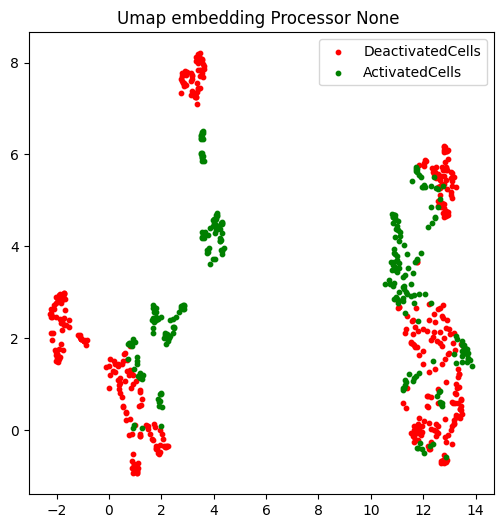

In [ ]:
#Case I
case_I = PreprocessorFeaturizer( preprocess = False ,
                           preprocessor = None
)
                  

/var/folders/mq/wmysw9td2xb1l5pq1h814lyr0000gn/T/ipykernel_4753/1901984213.py:117: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.resize(INPUT_SIZE, resample=Image.BICUBIC)


32/32 [==============================] - 4s 109ms/step
0.9504950495049505


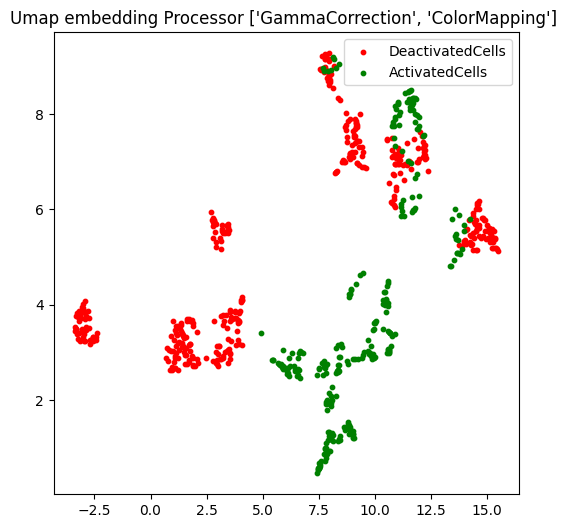

In [ ]:
# Case II
case_II = PreprocessorFeaturizer(preprocess = True ,
                           preprocessor = ['GammaCorrection','ColorMapping']
                          

               )